# <font color=4CBB17>**Análisis exploratorio y Preprocesamiento**</font>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install tensorflow

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
from tensorflow.keras.utils import to_categorical  # convertir etiquetas a one-hot encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
import itertools

In [3]:
base_skin_dir = os.path.join('..', 'input')

# Fusionar imágenes de ambas carpetas HAM10000_images_part1.zip y HAM10000_images_part2.zip en un diccionario
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# Se usa un diccionario para poner los nombres completos a cada abreviatura
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
import zipfile
import os

# Ruta al archivo zip en Google Drive
zip_path1 = '/content/drive/MyDrive/cod/LEA3_health_7/data/HAM10000_images_part_1.zip'
zip_path2 = '/content/drive/MyDrive/cod/LEA3_health_7/data/HAM10000_images_part_2.zip'

# Carpeta destino donde se extraerán las imágenes
extract_to = '/content/ham10000_images'

# Crear carpeta si no existe, si ya existe, no lanza error
os.makedirs(extract_to, exist_ok=True)

# Extraer archivos
with zipfile.ZipFile(zip_path1, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

with zipfile.ZipFile(zip_path2, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [5]:
#glob permite buscar archivos que coincidan con un patrón, como *.jpg
from glob import glob

base_skin_dir = extract_to  # ahora apunta a '/content/ham10000_images'

# Diccionario por comprensión que mapea cada nombre de imagen (sin extensión jpg) a su ruta completa en base_skin_dir
imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(os.path.join(base_skin_dir, '*.jpg'))
}

In [6]:
import os

# Ruta al csv en Google Drive
csv_path = '/content/drive/MyDrive/cod/LEA3_health_7/data/HAM10000_metadata.csv'

# Leer el archivo csv
skin_df = pd.read_csv(csv_path)

# Verificar los primeros registros
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
# Se crea una columna con la ruta completa de cada imagen y otra con el nombre completo del tipo de lesión a partir de su abreviación

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)


In [8]:
# Lista ordenada con los nombres únicos de los tipos de lesión en la columna cell_type
categorias = pd.Categorical(skin_df['cell_type']).categories
categorias

Index(['Actinic keratoses', 'Basal cell carcinoma',
       'Benign keratosis-like lesions ', 'Dermatofibroma', 'Melanocytic nevi',
       'Melanoma', 'Vascular lesions'],
      dtype='object')

In [9]:
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes # El número se asigna de acuerdo con el orden en que aparece arriba,
                                                                      # .codes lo que hace es devolver un array de enteros que representa
                                                                      # a cada categoría como un número

## <font color=FF7F50>**Distribución de los tipos de lesiones**</font>

<Axes: ylabel='cell_type'>

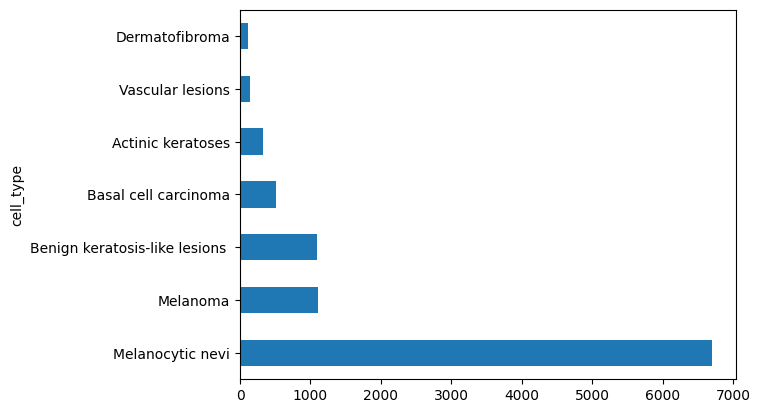

In [10]:
skin_df['cell_type'].value_counts().plot(kind='barh')

Al analizar la distribución de las categorías dentro del conjunto de datos, se evidencia un marcado desbalance en las clases correspondientes a los distintos tipos de lesiones dermatológicas. Este desequilibrio puede afectar negativamente el desempeño y la capacidad generalizadora de los modelos de clasificación que se deseen implementar.

Por ello, se recomienda realizar una recodificación de la variable original agrupando las lesiones en dos categorías, de acuerdo con su naturaleza clínica:

* Clase 1 (lesiones malignas):
Actinic keratoses, Basal cell carcinoma, Melanoma

* Clase 0 (lesiones benignas):
Melanocytic nevi, Dermatofibroma, Benign keratosis-like lesions, Vascular lesions

Con esta transformación se busca simplificar el problema de clasificación, convirtiéndolo en un escenario binario, lo que facilita la interpretación de los resultados, ya que se quiere coayudar a un diagnostico mas rapido, mejora la estabilidad del modelo y mitiga los efectos del desbalance de clases.



In [11]:
# Se verifican las 3 columnas creadas
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/ham10000_images/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [12]:
## cambiamos la etiqueta de 0 a 6 por una binaria teniendo en cuenta si las lesiones son malignas o benignas
malignas = ['Actinic keratoses', 'Basal cell carcinoma', 'Melanoma']

# Crear una nueva columna binaria donde 1 = maligna, 0 = benigna
skin_df['cell_type_idx'] = skin_df['cell_type'].apply(lambda x: 1 if x in malignas else 0)


In [13]:
# Se verifican la nueva columna
skin_df.head(10000)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0027419.jpg,Benign keratosis-like lesions,0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0025030.jpg,Benign keratosis-like lesions,0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0026769.jpg,Benign keratosis-like lesions,0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0025661.jpg,Benign keratosis-like lesions,0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/ham10000_images/ISIC_0031633.jpg,Benign keratosis-like lesions,0
...,...,...,...,...,...,...,...,...,...,...
9995,HAM_0000193,ISIC_0027950,akiec,histo,60.0,female,face,/content/ham10000_images/ISIC_0027950.jpg,Actinic keratoses,1
9996,HAM_0006180,ISIC_0027615,akiec,histo,70.0,male,upper extremity,/content/ham10000_images/ISIC_0027615.jpg,Actinic keratoses,1
9997,HAM_0006180,ISIC_0028990,akiec,histo,70.0,male,upper extremity,/content/ham10000_images/ISIC_0028990.jpg,Actinic keratoses,1
9998,HAM_0004282,ISIC_0033358,akiec,histo,65.0,female,face,/content/ham10000_images/ISIC_0033358.jpg,Actinic keratoses,1


## <font color=FF7F50>**Distribución por sexo**</font>

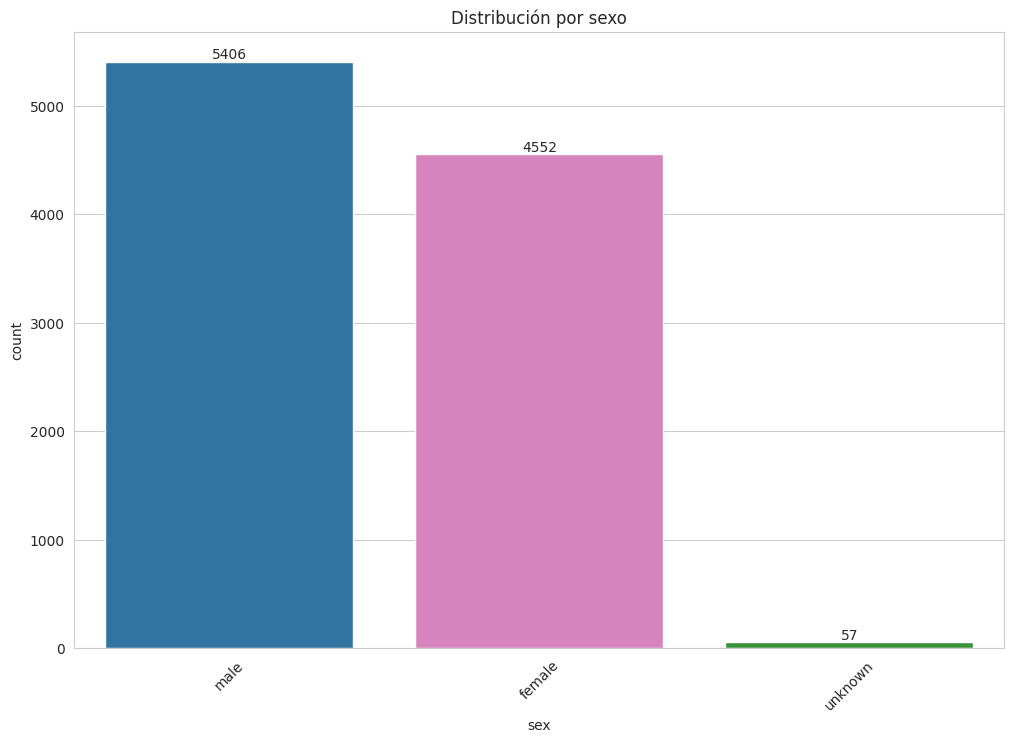

In [14]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize=(12, 8))

colores = ['#1f77b4', '#e377c2', '#2ca02c']

ax = sns.countplot(x='sex', hue='sex', data=skin_df, palette=colores)
for container in ax.containers:
    ax.bar_label(container)

plt.title('Distribución por sexo')
plt.xticks(rotation=45)
plt.show()

Se observa una mayor cantidad de hombres que mujeres en el conjunto de datos; sin embargo, la diferencia entre ambos sexos no es considerablemente amplia.

## <font color=FF7F50>**Tipo de lesión por sexo**</font>



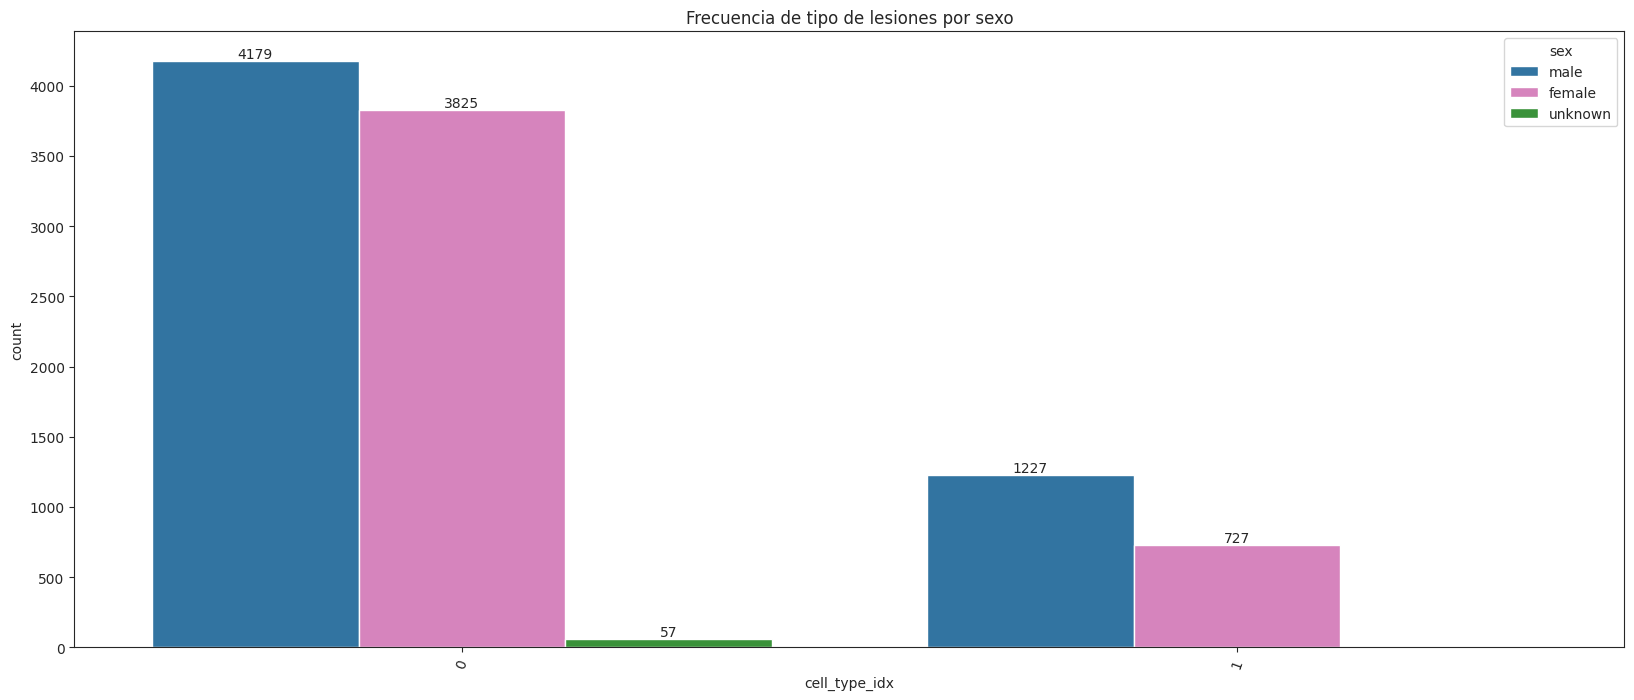

In [15]:
sns.set_style('ticks')
fig,axes = plt.subplots(figsize=(20,8))
ax = sns.countplot(x='cell_type_idx',hue='sex', data=skin_df, order = skin_df['cell_type_idx'].value_counts().index, palette = colores)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Frecuencia de tipo de lesiones por sexo')
plt.xticks(rotation=70)
plt.show()

En el grupo de lesiones benignas, no se observa una diferencia marcada entre hombres y mujeres. Sin embargo, al analizar los casos de lesiones malignas (1,954), se evidencia una mayor proporción en hombres, quienes representan el 63% de los diagnósticos, frente al 37% correspondiente a mujeres.

Es importante tener en cuenta que, del total de 9.958 pacientes clasificados según sexo, 5,406 son hombres (54.3%) y 4.552 son mujeres (45.7%). Por lo tanto, aunque los hombres constituyen una ligera mayoría en el conjunto de pacientes, su participación en los casos malignos es significativamente mayor, lo que sugiere una posible asociación entre el sexo masculino y una mayor incidencia de este tipo de lesiones.



## <font color=FF7F50>**Localización de las lesiones cutáneas**</font>


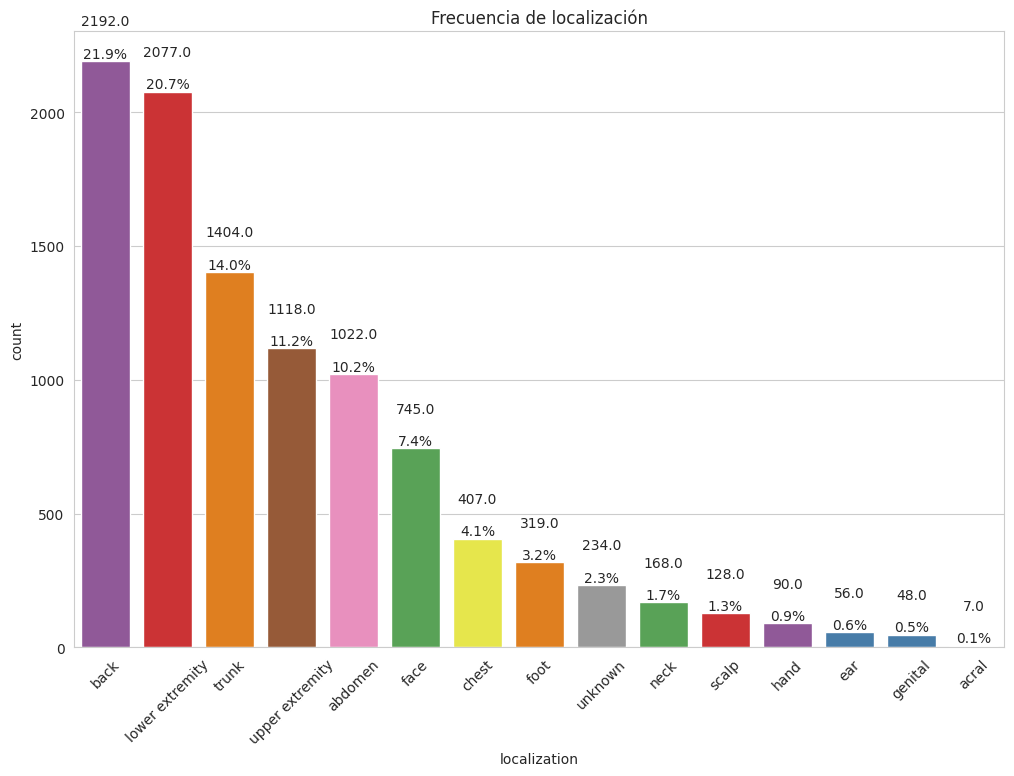

In [16]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
total = len(skin_df)

ax = sns.countplot(x='localization',hue='localization', data=skin_df, order = skin_df['localization'].value_counts().index, palette = 'Set1')
for container in ax.containers:
    labels = [f'{v.get_height()}\n\n{(v.get_height()/total)*100:.1f}%' for v in container]
    ax.bar_label(container, labels=labels)

plt.title('Frecuencia de localización')
plt.xticks(rotation=45)
plt.show()


Se observa que la ubicación más frecuente de las lesiones se encuentra en la espalda, el tren inferior, el torso y el tren superior. Esto podría estar asociado a varios factores:

* Son áreas que suelen estar expuestas al sol con mayor frecuencia, lo que incrementa el riesgo de daño cutáneo y la aparición de lesiones.

* Estas regiones ocupan una mayor superficie del cuerpo, lo que aumenta la probabilidad de que presenten alteraciones dermatológicas.

* La espalda, en particular, no suele ser revisada con regularidad por las personas, lo que retrasa la detección de anomalías y favorece la acumulación de lesiones visibles solo durante exámenes médicos.

* Las extremidades están más expuestas a traumatismos, fricción con la ropa o contacto con superficies, lo que puede desencadenar o agravar ciertos tipos de lesiones.

## <font color=FF7F50>**Localización por tipo de lesión (maligna y benigna)**</font>


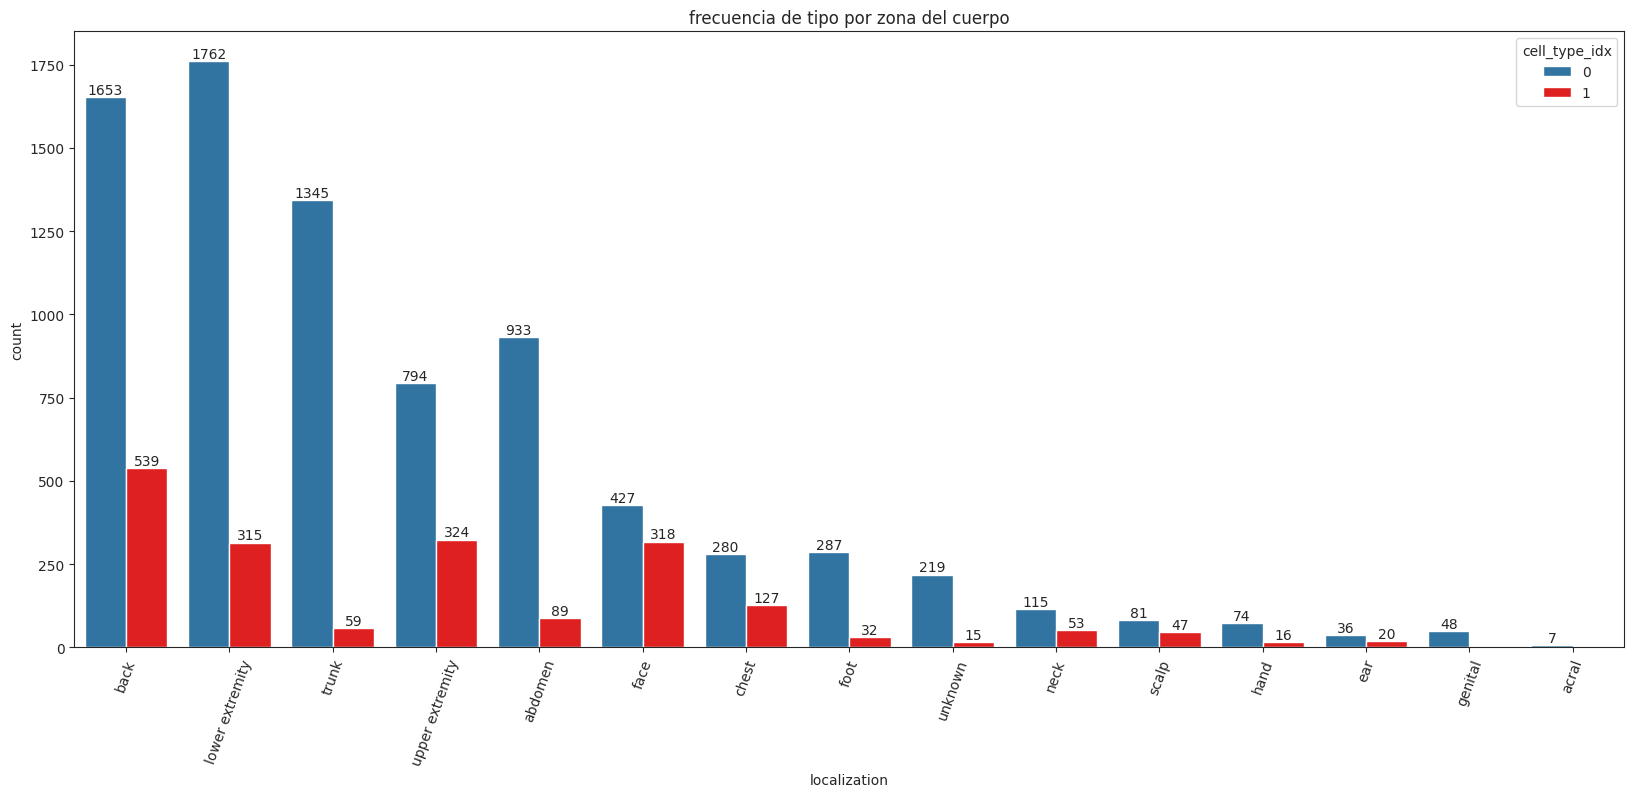

In [17]:
sns.set_style('ticks')
fig,axes = plt.subplots(figsize=(20,8))
ax = sns.countplot(x='localization',hue='cell_type_idx', data=skin_df, order = skin_df['localization'].value_counts().index, palette =['#1f77b4', 'red'])
for container in ax.containers:
    ax.bar_label(container)
plt.title('frecuencia de tipo por zona del cuerpo')
plt.xticks(rotation=70)
plt.show()

Se observa que las lesiones ubicadas en la cara tienen una mayor probabilidad de ser cancerosas en comparación con otras partes del cuerpo, como el tronco, las extremidades inferiores o el abdomen.
También es relevante señalar que el cuero cabelludo (scalp), la oreja (ear) y el cuello (neck) son zonas que presentan una incidencia notable de este tipo de lesiones malignas.

## <font color=FF7F50>**Tipo de examen (maligna y benigna)**</font>

* Histo (Histopatología):
Diagnóstico basado en el análisis microscópico de una muestra de tejido. Es considerado el método más preciso para identificar lesiones malignas.

* Follow-up (Seguimiento):
Diagnóstico determinado a partir de la observación clínica de la evolución de la lesión a lo largo del tiempo, sin intervención inmediata.

* Consensus (Consenso clínico):
Diagnóstico acordado por varios dermatólogos expertos al evaluar conjuntamente las imágenes o características clínicas de la lesión.

* Confocal (Microscopía confocal):
Diagnóstico realizado mediante imágenes de alta resolución obtenidas con microscopía láser confocal, una técnica no invasiva que permite observar estructuras celulares en la piel en tiempo real.

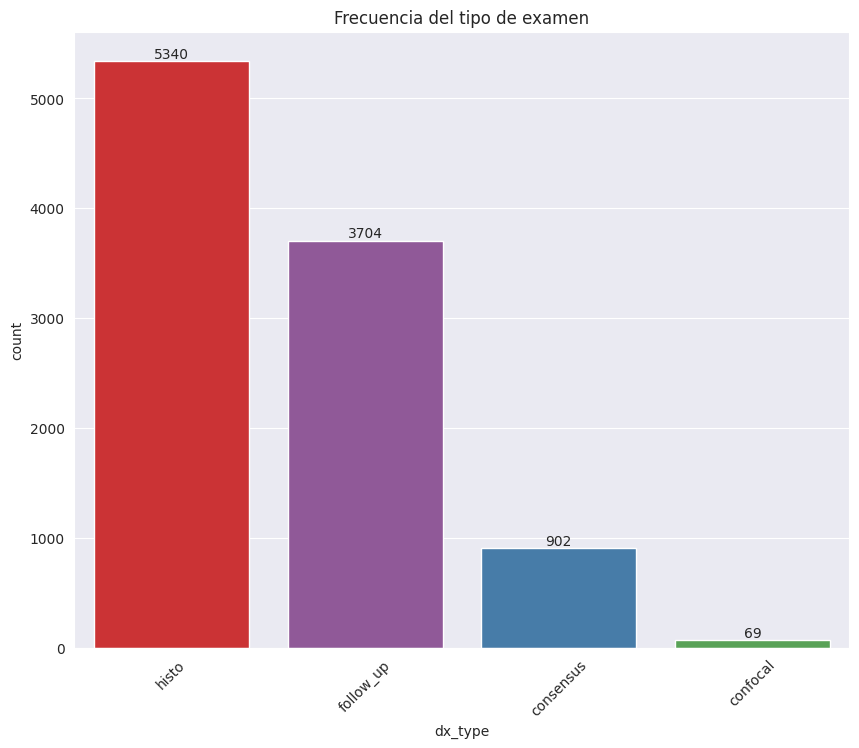

In [18]:
sns.set_style('darkgrid')
fig,axes = plt.subplots(figsize=(10,8))
ax = sns.countplot(x='dx_type', hue= 'dx_type',data=skin_df, order = skin_df['dx_type'].value_counts().index, palette = 'Set1')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Frecuencia del tipo de examen')
plt.xticks(rotation=45)
plt.show()

El criterio diagnóstico más frecuente corresponde a la histopatología, considerada la técnica más precisa para la identificación de lesiones cutáneas.
A este le sigue el diagnóstico derivado de actividades de seguimiento clínico (follow-up), que representa también una proporción significativa de los casos. Las demás metodologías, como el consenso clínico y la confocal, son menos utilizadas.

## <font color=FF7F50>**Lesiones por edad**</font>


In [19]:
skin_df.isnull().sum()


,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0
path,0
cell_type,0
cell_type_idx,0


In [20]:
# Reemplaza los valores nulos de la columna age del df por el valor promedio de esa columna
skin_df['age'] = skin_df['age'].fillna(skin_df['age'].mean())

In [21]:
skin_df.isnull().sum()


,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,0
sex,0
localization,0
path,0
cell_type,0
cell_type_idx,0


In [22]:
import plotly.express as px

fig = px.histogram(
    skin_df,
    x="age",
    color="cell_type_idx",
    barmode="stack",
    title="Lesión (maligna vs benigna) según la edad",
    nbins=20
)

fig.update_layout(bargap=0.05)
fig.show()

Se puede observar que, a medida que el paciente envejece, aumenta la probabilidad de desarrollar lesiones malignas en la piel, con un incremento más marcado a partir de los 50 años. Esto puede explicarse por la acumulación progresiva de daño solar a lo largo de la vida y el envejecimiento de la piel que conllevan a una mayor susceptibilidad a mutaciones que pueden derivar en cáncer cutáneo. Esta tendencia resalta la importancia del seguimiento dermatológico en adultos mayores y de promover estrategias de prevención desde edades tempranas.

In [23]:
print(skin_df.dtypes)


lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx      int64
dtype: object


Realizar exploración

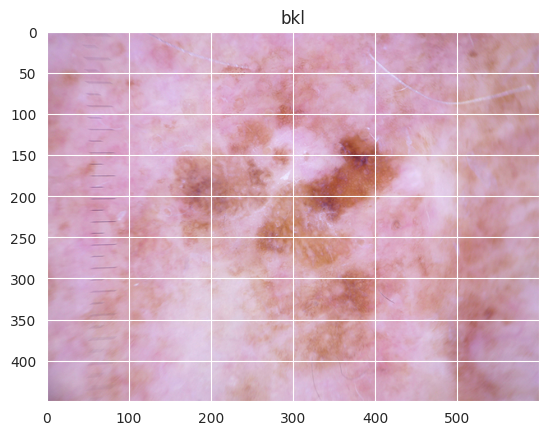

In [24]:
import cv2
import matplotlib.pyplot as plt

# Obtener la ruta de la imagen
ruta_imagen = skin_df.loc[skin_df['image_id'] == 'ISIC_0027419', 'path'].values[0]

# Leer la imagen con OpenCV (en BGR)
img_cv2 = cv2.imread(ruta_imagen)

# Convertir a RGB para mostrarla correctamente con matplotlib
img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

# Mostrarla
plt.imshow(img_rgb)
plt.title('bkl')
plt.show()

In [25]:
img_rgb.shape

(450, 600, 3)

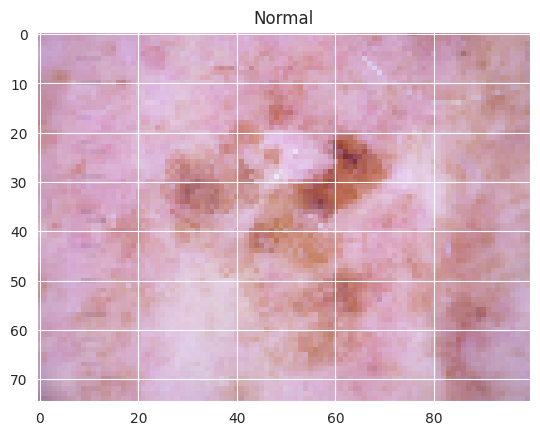

np.int64(22500)

In [26]:
img2_r = cv2.resize(img_rgb ,(100,75))
plt.imshow(img2_r)
plt.title('Normal')
plt.show()
np.prod(img2_r.shape)


Se va a redimensionar las imágenes 125 x 100, ya que esto nos ofrece una buena calidad al estar limitados de recursos.

En una consulta realizada a dos médicos cercanos, se estableció que, para contar con un buen criterio de valoración clínica, es fundamental observar detalles como los bordes regulares, la tonalidad, los relieves (elevaciones o depresiones), la descamación y la presencia de vasos sanguíneos alrededor de la lesión. Al mostrarles las imágenes en dos resoluciones diferentes (100x75 y 125x100), ambos coincidieron en que la segunda alternativa ofrece una mejor percepción visual, ya que la primera se ve un poco más pixelada, dificultando la evaluación de los detalles mencionados.

In [27]:
# Crear una nueva columna que contiene la imagen en forma de array redimensionada
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [28]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0027419.jpg,Benign keratosis-like lesions,0,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0025030.jpg,Benign keratosis-like lesions,0,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0026769.jpg,Benign keratosis-like lesions,0,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/ham10000_images/ISIC_0025661.jpg,Benign keratosis-like lesions,0,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/ham10000_images/ISIC_0031633.jpg,Benign keratosis-like lesions,0,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


In [29]:
# Número de muestras por clase que se van a mostrar
n_samples = 5

# Se crea una figura con subplots de 7 filas, una por tipo de lesión 5 columnas
fig, m_axs = plt.subplots(7, n_samples, figsize=(4 * n_samples, 3 * 7))

# Se recorren simultáneamente los ejes de cada fila n_axs y los grupos del df según el cell_type
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):

    # Se coloca el nombre del tipo de lesión (cell_type) como título del primer gráfico de la fila
    n_axs[0].set_title(type_name)

    # Para cada eje (c_ax) y fila del grupo correspondiente (tipo de lesión), se seleccionan n_samples aleatorios
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off') # Se ocultan ejes

# Se guarda la figura generada como una imagen en disco
fig.savefig('category_samples.png', dpi=200)

Output hidden; open in https://colab.research.google.com to view.

In [30]:
# Se revisa la imagen para confirmar cada dimensión (alto, ancho, canales)

skin_df['image'].map(lambda x: x.shape).value_counts()


,count
image,
"(75, 100, 3)",10015


In [31]:
x=skin_df.drop(columns=['cell_type_idx'],axis=1)
y=skin_df['cell_type_idx']

In [32]:
#Para un Random Forest o XGBoost (imágenes + datos tabulares)
from sklearn.preprocessing import MinMaxScaler


# 1. Procesar variables tabulares
X_tab = skin_df[['age', 'sex', 'localization']].copy()

# Escalar 'age'
scaler = MinMaxScaler()
X_tab['age'] = scaler.fit_transform(X_tab[['age']])

# One-hot encoding para variables categóricas
X_tab = pd.get_dummies(X_tab, columns=['sex', 'localization'], drop_first=True)

# 2. Aplanar imágenes
X_img_flat = np.stack(skin_df['image'].values)            # (n, 100, 75, 3)
X_img_flat = X_img_flat.reshape(X_img_flat.shape[0], -1)  # (n, 22500)

# 3. Concatenar imagen y datos tabulares
X_rf = np.concatenate([X_img_flat, X_tab.values], axis=1)
y_rf = y.copy()

In [33]:
x_train, x_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.20,random_state=123)

In [34]:
# Imágenes en formato (n_samples, alto, ancho, canales)
X_cnn = np.stack(skin_df['image'].values)

# Etiquetas
y_cnn = skin_df['cell_type_idx'].values

X_cnn = X_cnn / 255.0

In [35]:
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_cnn, test_size=0.20, random_state=123)

In [36]:
import joblib

output_path = '/content/drive/MyDrive/cod/LEA3_health_7/salidas'
os.makedirs(output_path, exist_ok=True)

# Guardar archivos correctamente
joblib.dump(x_train, f"{output_path}/x_train.pkl")
joblib.dump(x_test, f"{output_path}/x_test.pkl")
joblib.dump(y_train, f"{output_path}/y_train.pkl")
joblib.dump(y_test, f"{output_path}/y_test.pkl")



['/content/drive/MyDrive/cod/LEA3_health_7/salidas/y_test.pkl']

In [37]:
joblib.dump(X_train_cnn, f"{output_path}/X_train_cnn.pkl")
joblib.dump(y_train_cnn, f"{output_path}/y_train_cnn.pkl")
joblib.dump(X_test_cnn, f"{output_path}/X_test_cnn.pkl")
joblib.dump(y_test_cnn, f"{output_path}/y_test_cnn.pkl")

['/content/drive/MyDrive/cod/LEA3_health_7/salidas/y_test_cnn.pkl']